# Basic Demonstration of Image Object Detection and Localization

#### Choose base directory

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\INCUBAÇÃO\Cameras


#### Install packages

deep-learning libraries , may have to update:


In [ ]:
# ! conda install pytorch torchvision -c pytorch -y

#### Import Libraries

In [40]:
from sklearn import feature_selection as fs

# vision modules
import torchvision
from torchvision import  transforms 
import torch
from torch import no_grad

# libraries for getting data from the web
import requests

# libraries  for image processing and visualization
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

#### Define Auxiliary Functions

This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold.


In [25]:
def get_predictions(pred, threshold=0.8, objects=None):
    """
    This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold 
    
    pred: a list where each element contains a tuple that corresponds to information about  the different
    objects; Each element includes a tuple with the class yhat, probability of belonging to that class
    and the coordinates of the bounding box corresponding to the object 
    image : frozen surface
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the
    different objects; Each element includes a tuple with the class name, probability of belonging to that class
    and the coordinates of the bounding box corresponding to the object 
    thre
    """
    predicted_classes = [(
        COCO_INSTANCE_CATEGORY_NAMES[i], p, [(box[0], box[1]), (box[2], box[3])]) for i, p, box in zip(
            list(pred[0]['labels'].numpy()),
            pred[0]['scores'].detach().numpy(),
            list(pred[0]['boxes'].detach().numpy())
    )]
    
    predicted_classes = [stuff for stuff in predicted_classes if stuff[1] > threshold]
    
    if objects  and predicted_classes :
        predicted_classes=[ (name, p, box) for name, p, box in predicted_classes if name in  objects ]

    return predicted_classes

# Here are the 91 classes.
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

Draws box around each object


In [26]:
def draw_box(predicted_classes, image, rect_th=2, text_size=1, text_color=(0, 255, 0), text_th=3, show=True):
    """
    draws box around each object 
    
    predicted_classes: a list where each element contains a tuple that corresponds to information
    about  the different objects; Each element includes a tuple with the class name, probability
    of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface 
    """
    img = (np.clip(cv2.cvtColor(np.clip(image.numpy().transpose((1, 2, 0)), 0, 1), cv2.COLOR_RGB2BGR), 0, 1) * 255).astype(np.uint8).copy()
    for predicted_class in predicted_classes:
   
        label = predicted_class[0]
        probability = predicted_class[1]
        box = predicted_class[2]
        for i in [0, 1]:
            box[i] = (int(box[i][0]), int(box[i][1]))
        
        cv2.rectangle(img, box[0], box[1],(0, 255, 0), rect_th) # Draw Rectangle with the coordinates
        cv2.putText(img,label, box[0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0, 255, 0), thickness=text_th) 
        cv2.putText(img,label + ": " + str(round(probability, 2)), box[0], cv2.FONT_HERSHEY_SIMPLEX, text_size, text_color, thickness=text_th)
    # if len(predicted_classes):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if show: plt.imshow(img)
    # del(img)
    # del(image)
    return img

This function  will speed up your code by freeing memory.

In [27]:
def save_RAM(image_=False):
    global image, img, pred
    torch.cuda.empty_cache()
    del(img)
    del(pred)
    if image_:
        image.close()
        del(image)

#### Applies function to frames from video stream and return listed results

In [28]:
# Image processing library
import cv2

# Progress reporting class
from modules.controlled_pipeline import Progress

# Clear output function
from IPython.display import clear_output as co

def apply_to_video_frames(func, video_path, max_frames=None, report_each=None):
    index = 0
    res = []
    cap = cv2.VideoCapture(video_path)
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    progress = Progress(n_frames)
    while True:
        if max_frames is not None and index == max_frames:
            break
        ret, frame = cap.read()
        if not ret:
            break
        # Process the frame here
        res.append(func(frame, index))
        index += 1
        if report_each is not None and index % report_each == 0:
            co(True); progress.report(index)
    return res

#### Object detection for given frame

In [29]:
p = None

def predict(frame, index=0):
    if p is not None:
        new_size = [int(p * s) for s in reversed(image.size[:2])]
        frame = cv2.resize(frame, new_size) # if numpy array image
    # frame.resize([int(p * s) for s in image.size]) # if pil image
    # We convert the image to a tensor.
    img = transform(frame)
    pred = model([img])
    return pred

from time import sleep
from IPython.display import clear_output as co

#### Draw boxes and display frame

In [30]:
# default function parameters
fps = 1
p = None
threshold = 0.8
objects = None
rect_th = 2
text_size = 0.8
text_th = 2

def annotate_and_display(frame, index):
    pred = frames_pred[index]
    pred_class = get_predictions(pred, threshold, objects)
    if p is not None:
        new_size = [int(p * s) for s in reversed(image.size[:2])]
        frame = cv2.resize(frame, new_size) # if numpy array image
    img = transform(frame)
    draw_box(pred_class, img, rect_th, text_size, text_th=text_th, show=True)
    plt.show()
    display(sorted(pred_class))
    co(True)
    sleep(1 / fps)

#### Draw boxes and write frame to video file using `WRITER` instance

In [31]:
WRITER = None

p = None
threshold = 0.8
objects = None
rect_th = 2
text_size = 1
text_th = 3

def annotate_and_write(frame, index):
    pred = frames_pred[index]
    pred_class = get_predictions(pred, threshold, objects)
    if p is not None:
        new_size = [int(p * s) for s in reversed(image.size[:2])]
        frame = cv2.resize(frame, new_size) # if numpy array image
    img = transform(frame)
    img_draw = draw_box(pred_class, img, rect_th, text_size, text_th=text_th, show=False)
    WRITER.write(img_draw)

#### Class to write videos

In [32]:
import os, cv2

class Video:

    def __init__(self, codec:str='mp4v', fps:int=3, shape:tuple=(854, 480), overwrite=False):
        self.codec = codec; self.fps = fps; self.shape = shape
        self.overwrite = overwrite

    def writer(self, path):
        if not self.overwrite and os.path.exists(path):
            print(f'ANNOTATE VIDEO TIMESTAMP FAILED. FILE ALREADY EXISTS · FILE-PATH: {path}')
            return False
        return cv2.VideoWriter(path, cv2.VideoWriter_fourcc(*self.codec), self.fps, self.shape)

#### Function to get basic metadata from video file:
    fps: frames per second (FPS) of video file
    shape: shape of first frame

In [23]:
def get_video_metadata(video_path, transform=None):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS) # get the fps
    _, frame = cap.read() # read the first frame
    if transform is not None: # custom transformation
        frame = transform(frame)
    shape = frame.shape; # get the shape
    cap.release(); cv2.destroyAllWindows()
    return fps, shape

---
## Load Pre-trained Faster R-CNN

<a href='https://arxiv.org/abs/1506.01497?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera25797139-2021-01-01'>Faster R-CNN</a> is a model that predicts both bounding boxes and class scores for potential objects in the image  pre-trained on <a href="https://cocodataset.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkCV0101ENCoursera25797139-2021-01-01">COCO<a>.


In [43]:
model_ = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model_.eval()

for name, param in model_.named_parameters():
    param.requires_grad = False
print("done")

C:\Users\luisr\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\luisr\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


done


the function calls Faster R-CNN <code> model\_ </code> but save RAM:


In [44]:
def model(x):
    with torch.no_grad():
        yhat = model_(x)
    return yhat

We will create a transform object to convert the image to a tensor.

In [41]:
# We will create a transform object to convert the image to a tensor.
transform = transforms.Compose([transforms.ToTensor()])

---
## Object Detection and Localization

In Object Localization we locate the presence of objects in an image and indicate the location with a bounding box.

#### Load sample image

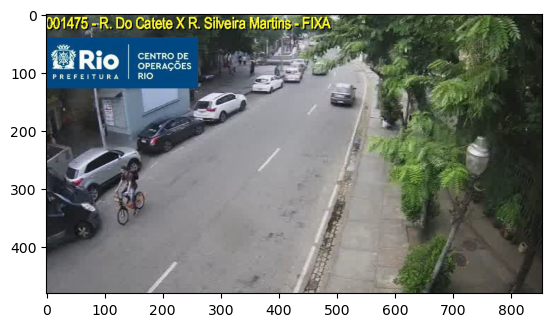

In [14]:
img_path = 'Dados/images/1475/reference/day/CODE1475_20230329_16-40-54.jpg'

image = Image.open(img_path)

# Resize image
p = 0.5
# image.resize([int(p * s) for s in image.size])

plt.imshow(image)
plt.show()

#### Transform and predict

In [15]:
# Resize image
p = 0.5
# image.resize([int(p * s) for s in image.size])

# We convert the image to a tensor.
img = transform(image)

# we can make a prediction,The output is a dictionary with several predicted classes,
# the probability of belonging to that class and the coordinates of the bounding box
# corresponding to that class.
pred = model([img])

<b>note</b>:  if you call <code>model\_(\[img])</code>  directly but it will use more RAM


#### Show predictions for specific objects

We can localize objects; we do this using the function <code>get_predictions</code>. The input  is the predictions <code>pred</code> and the <code>objects</code> you would like to localize .


[('bicycle', 0.89147854, [(116.12769, 278.06424), (167.74672, 361.33795)]),
 ('car', 0.5679265, [(422.31027, 76.44601), (451.48547, 95.969574)]),
 ('car', 0.6995002, [(485.86746, 118.40953), (532.1912, 159.43513)]),
 ('car', 0.7986052, [(457.59933, 82.0334), (484.61148, 106.562164)]),
 ('car', 0.82734156, [(405.2839, 86.1989), (444.17303, 119.21694)]),
 ('car', 0.9783917, [(31.58229, 224.86145), (161.13202, 316.74564)]),
 ('car', 0.98787284, [(253.37712, 133.5474), (346.21613, 188.54456)]),
 ('car', 0.9907973, [(352.89868, 103.55268), (410.06372, 137.00009)]),
 ('car', 0.9979438, [(151.34212, 171.0248), (273.8275, 243.74515)]),
 ('person', 0.5148386, [(330.8206, 71.93331), (337.80765, 88.28425)]),
 ('person', 0.5268298, [(338.3551, 73.494705), (345.28806, 88.424355)]),
 ('person', 0.8369951, [(350.09756, 79.29016), (359.7304, 106.449646)]),
 ('person', 0.9533585, [(124.70529, 261.29703), (159.76256, 330.1983)])]

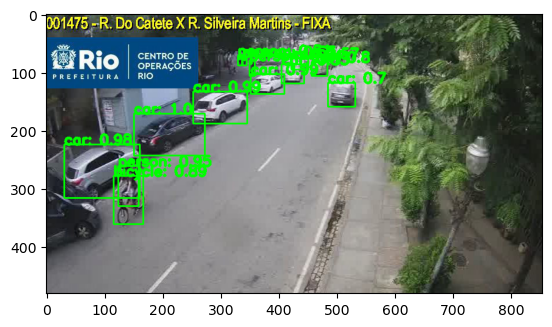

In [16]:
objects = ["person", "bicycle", "car"]
pred_class = get_predictions(pred, threshold=0.5, objects=objects)

display(sorted(pred_class))
img_draw = draw_box(pred_class, img, text_size=0.8)

#### Set lower threshold / detect any objects

[('bicycle', 0.89147854, [(116.12769, 278.06424), (167.74672, 361.33795)]),
 ('car', 0.6995002, [(485.86746, 118.40953), (532.1912, 159.43513)]),
 ('car', 0.7986052, [(457.59933, 82.0334), (484.61148, 106.562164)]),
 ('car', 0.82734156, [(405.2839, 86.1989), (444.17303, 119.21694)]),
 ('car', 0.9783917, [(31.58229, 224.86145), (161.13202, 316.74564)]),
 ('car', 0.98787284, [(253.37712, 133.5474), (346.21613, 188.54456)]),
 ('car', 0.9907973, [(352.89868, 103.55268), (410.06372, 137.00009)]),
 ('car', 0.9979438, [(151.34212, 171.0248), (273.8275, 243.74515)]),
 ('motorcycle', 0.67123, [(2.9415781, 276.1688), (96.83551, 399.47723)]),
 ('person', 0.8369951, [(350.09756, 79.29016), (359.7304, 106.449646)]),
 ('person', 0.9533585, [(124.70529, 261.29703), (159.76256, 330.1983)]),
 ('potted plant', 0.6424763, [(770.92474, 311.34674), (820.7032, 391.2498)])]

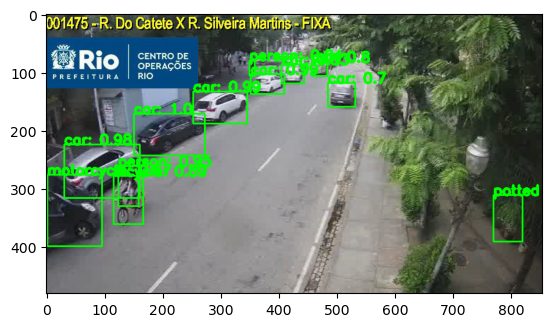

In [17]:
pred_class = get_predictions(pred, threshold=0.6, objects=None)

display(sorted(pred_class))
img_draw = draw_box(pred_class, img, text_size=0.8)

---
## Video Object Detection

#### Detect objects in video stream

In [156]:
video_path = 'Dados/Demos/sample-videos-smartphone/VID_20230515_125536.mp4'

# resize factor
p = None

frames_pred = apply_to_video_frames(predict, video_path, report_each=1, max_frames=None)


- PROGRESS: 293 / 293 ops · PROGRESS-PRCT: 100.0 %

- RUNNING: 33.2 min · EXPECT-FINISH: 0.0 min · RATE: 0.1469 ops / s


#### Watch video stream with object detection results

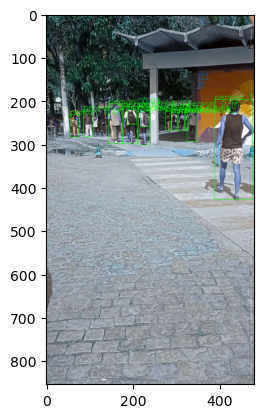

[('backpack', 0.93420005, [(187, 221), (208, 254)]),
 ('backpack', 0.9435724, [(217, 223), (241, 260)]),
 ('person', 0.81768876, [(319, 227), (329, 264)]),
 ('person', 0.9435497, [(86, 221), (109, 282)]),
 ('person', 0.9468252, [(55, 232), (77, 284)]),
 ('person', 0.95616275, [(289, 227), (303, 267)]),
 ('person', 0.96983856, [(275, 224), (290, 268)]),
 ('person', 0.9733429, [(213, 213), (239, 302)]),
 ('person', 0.9776509, [(325, 212), (349, 294)]),
 ('person', 0.97782475, [(178, 213), (211, 299)]),
 ('person', 0.9779588, [(305, 226), (321, 269)]),
 ('person', 0.9858472, [(144, 207), (176, 299)]),
 ('person', 0.99916005, [(389, 197), (476, 428)])]

In [127]:
# Object detection parameters

p = 1 # resize factor
threshold = 0.8
objects = None
rect_th = 1
text_size = .6
text_th = 1

fps, shape = get_video_metadata(video_path)
# fps = 3

res = apply_to_video_frames(annotate_and_display, video_path, max_frames=10)

#### Custom image preprocessing

In [144]:
def custom_transform(frame):
    if p is not None:
        new_size = [int(p * s) for s in reversed(image.size[:2])]
        frame = cv2.resize(frame, new_size) # if numpy array image
    img = transform(frame)
    return draw_box([], img, show=False)

#### Write demo video file

In [157]:
from datetime import datetime as dt

p = None # resize factor

# fps = 3
fps, shape = get_video_metadata(video_path, transform=custom_transform)
shape = tuple(reversed(shape[:2])) # witdth, height
overwrite = True

video_write_path = f'Dados/Demos/object-detection/{video_path.split("/")[-1]}'

# OPEN VIDEO FILE WRITER
video = Video(fps=fps, shape=shape, overwrite=overwrite)
WRITER = video.writer(path=video_write_path)

# Object detection parameters
# p = 1 # resize factor
threshold = 0.9
objects = None
rect_th = 2
text_size = 1
text_th = 2

res = apply_to_video_frames(annotate_and_write, video_path, report_each=5, max_frames=None)

# CLOSE/RELEASE VIDEO FILE WRITER
WRITER.release(); cv2.destroyAllWindows()

# Get current date as string
today = dt.now().date().isoformat()
print(f'\nVideo file {video_write_path} saved at: {today}')


- PROGRESS: 290 / 293 ops · PROGRESS-PRCT: 99.0 %

- RUNNING: 1.1 min · EXPECT-FINISH: 0.0 min · RATE: 4.3598 ops / s

Video file Dados/Demos/object-detection/VID_20230515_125536.mp4 saved at: 2023-05-16


## Extra: Object tracking with OpenCV

In [59]:
import cv2
from datetime import datetime as dt

fps, shape = get_video_metadata(video_path, transform=None)
shape = (shape[1], shape[0]) # witdth, height
overwrite = True

video_path = 'Dados/Demos/sample-videos-smartphone/VID_20230515_125107.mp4'
video_write_path = f'Dados/Demos/tracking/tracking-{video_path.split("/")[-1]}'

# OPEN VIDEO FILE WRITER
video = Video(fps=fps, shape=shape, overwrite=overwrite)
WRITER = video.writer(path=video_write_path)

# Create a tracker object
tracker = cv2.TrackerCSRT_create()

# Load the video
video = cv2.VideoCapture(video_path)

# Read the first frame
ret, frame = video.read()

# detect objects and get start bounding boxes
pred = predict(frame, 0)
pred_class = get_predictions(pred, threshold=0.2, objects=['backpack'])
corners = pred_class[0][2]
bbox = tuple(map(int, (corners[0][0], corners[0][1], corners[1][0] - corners[0][0], corners[1][1] - corners[0][1])))

# Select manually the region of interest (ROI) to track
# bbox = cv2.selectROI('Object Tracking', frame, False)

# Initialize the tracker with the ROI coordinates
tracker.init(frame, bbox)

i = 0
max_frames = None

while True:
    
    if max_frames is not None and i == max_frames:
        break
    
    # Read a new frame
    ret, frame = video.read()
    if not ret:
        break
    i += 1
    
    # Update the tracker
    success, bbox = tracker.update(frame)

    if success:
        # Draw bounding box
        x, y, w, h = [int(val) for val in bbox]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Print progress
    # ...
        
    # Display result
    # cv2.imshow('Object Tracking', frame)

    # Write result
    WRITER.write(frame)
    
    # Exit if ESC key is pressed
    if cv2.waitKey(1) == 27:
        break
        
# CLOSE/RELEASE VIDEO FILE WRITER
WRITER.release()

# Release resources
video.release()
cv2.destroyAllWindows()

# Get current date as string
today = dt.now().date().isoformat()
print(f'\nVideo file {video_write_path} saved at: {today}')


Video file Dados/Demos/tracking/tracking-VID_20230515_125107.mp4 saved at: 2023-05-19
